In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import itertools
import scipy
import os
import nept

from matplotlib import animation, rc
from IPython.display import HTML

from loading_data import get_data
from analyze_tuning_curves import get_only_tuning_curves
from analyze_decode_bytrial import decode_trial
from analyze_decode import get_decoded_zones
from utils_maze import find_zones, get_trials

In [2]:
thisdir = os.getcwd()
pickle_filepath = os.path.join(thisdir, "cache", "pickled")
output_filepath = os.path.join(thisdir, "plots", "decode-video")

In [3]:
import info.r068d6 as info

In [4]:
events, position, spikes, lfp, _ = get_data(info)

phase = "phase3"

position_initial = position.time_slice(info.task_times[phase].start, info.task_times[phase].stop)
spikes = [spiketrain.time_slice(info.task_times[phase].start, info.task_times[phase].stop) for spiketrain in spikes]

In [5]:
xedges, yedges = nept.get_xyedges(position_initial, binsize=4)

trial_epochs = get_trials(events, info.task_times[phase])

In [6]:
# for trial_idx in range(trial_epochs.n_epochs):
for trial_idx in [18]:
    trial_start = trial_epochs.starts[trial_idx]
    trial_stop = trial_epochs.stops[trial_idx]

    trial_times = nept.Epoch([trial_start, trial_stop])
    sliced_spikes, tuning_curves = get_only_tuning_curves(info, position, spikes, xedges, yedges, phase="phase3")

    decoding_times = trial_times
    shuffle_id = False
    speed_limit = 0.167
    t_smooth = 0.5
    dt = 0.025
    window = 0.025
    gaussian_std = 0.0075
    normalized = False
    min_neurons = 2
    min_spikes = 1

    position = position_initial.time_slice(decoding_times.start, decoding_times.stop)
    
    # limit position to only times when the subject is moving faster than a certain threshold
    run_epoch = nept.run_threshold(position, thresh=speed_limit, t_smooth=t_smooth)
    position = position[run_epoch]

    epochs_interest = nept.Epoch(np.array([position.time[0], position.time[-1]]))

    counts = nept.bin_spikes(sliced_spikes, position.time, dt=dt, window=window,
                             gaussian_std=gaussian_std, normalized=normalized)
    
    n_active_neurons = np.sum(counts.data >= 1, axis=1)

    tc_shape = tuning_curves.shape
    decoding_tc = tuning_curves.reshape(tc_shape[0], tc_shape[1] * tc_shape[2])

    likelihood = nept.bayesian_prob(counts, decoding_tc, window, min_neurons=min_neurons, min_spikes=min_spikes)

In [7]:
likelihood

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ..., 
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,  0.00041171, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

In [8]:
trial_epochs.n_epochs

46

53.7758676088


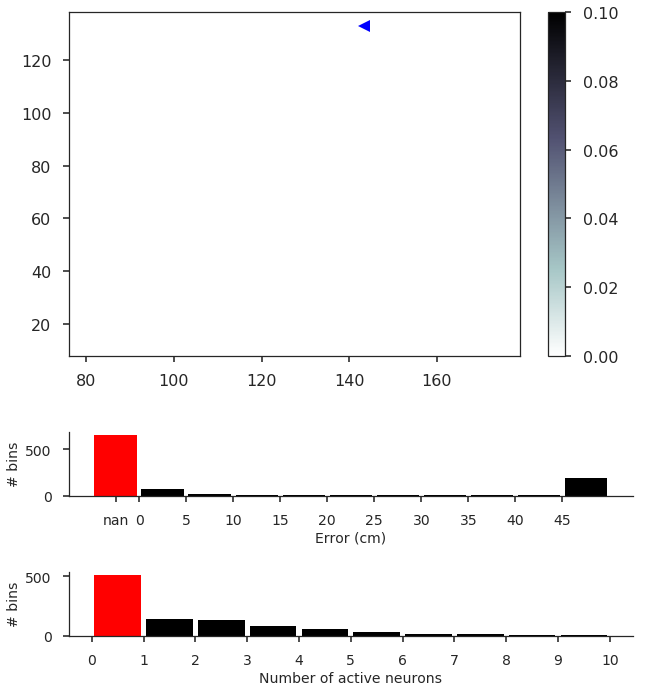

In [28]:
# for trial_idx in range(trial_epochs.n_epochs):
for trial_idx in [18]:
    trial_start = trial_epochs.starts[trial_idx]
    trial_stop = trial_epochs.stops[trial_idx]

    trial_times = nept.Epoch([trial_start, trial_stop])
    sliced_spikes, tuning_curves = get_only_tuning_curves(info, position, spikes, xedges, yedges, phase="phase3")

    decoding_times = trial_times
    shuffle_id = False
    speed_limit = 4.
    t_smooth = 0.5
    dt = 0.025
    window = 0.025
    gaussian_std = 0.0075
    normalized = False
    min_neurons = 2
    min_spikes = 1

    position = position_initial.time_slice(decoding_times.start, decoding_times.stop)
    
    # limit position to only times when the subject is moving faster than a certain threshold
    run_epoch = nept.run_threshold(position, thresh=speed_limit, t_smooth=t_smooth)
    position = position[run_epoch]

    epochs_interest = nept.Epoch(np.array([position.time[0], position.time[-1]]))

    counts = nept.bin_spikes(sliced_spikes, position.time, dt=dt, window=window,
                             gaussian_std=gaussian_std, normalized=normalized)
    
    n_active_neurons = np.sum(counts.data >= 1, axis=1)

    tc_shape = tuning_curves.shape
    decoding_tc = tuning_curves.reshape(tc_shape[0], tc_shape[1] * tc_shape[2])

    likelihood = nept.bayesian_prob(counts, decoding_tc, window, min_neurons=min_neurons, min_spikes=min_spikes)
    
    xcenters = (xedges[1:] + xedges[:-1]) / 2.
    ycenters = (yedges[1:] + yedges[:-1]) / 2.
    xy_centers = nept.cartesian(xcenters, ycenters)
    decoded_position = nept.decode_location(likelihood, xy_centers, counts.time)
    
    likelihood = likelihood.reshape(np.shape(likelihood)[0], tc_shape[1], tc_shape[2])
#     likelihood[np.isnan(likelihood)] = 0.

    f_xy = scipy.interpolate.interp1d(position.time, position.data.T, kind="nearest")
    counts_xy = f_xy(decoded_position.time)
    true_position = nept.Position(np.hstack((counts_xy[0][..., np.newaxis],
                                             counts_xy[1][..., np.newaxis])),
                                  decoded_position.time)
    
    errors = true_position.distance(decoded_position)
    print(np.nanmean(errors))


    fig = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(5, 4) 
    
    ax1 = plt.subplot2grid((5, 4), (0, 0), colspan=3, rowspan=3)

    xx, yy = np.meshgrid(xedges, yedges)

    pad_amount = 5
    ax1.set_xlim((np.floor(np.min(true_position.x))-pad_amount, np.ceil(np.max(true_position.x))+pad_amount))
    ax1.set_ylim((np.floor(np.min(true_position.y))-pad_amount, np.ceil(np.max(true_position.y))+pad_amount))

    n_timebins = len(likelihood)

    cmap = plt.cm.get_cmap('bone_r')
    posterior_position = ax1.pcolormesh(xx[:-1], yy[:-1], likelihood[0], vmin=0, vmax=0.1, cmap=cmap)
    colorbar = fig.colorbar(posterior_position, ax=ax1)

    estimated_position, = ax1.plot([], [], "<", color="r")
    rat_position, = ax1.plot([], [], "<", color="b")
    
    ax2 = plt.subplot2grid((5, 4), (3, 0), colspan=3)
    
    errors[np.isnan(errors)] = -1
    binwidth = 5.
    error_bins = np.arange(-binwidth, 50+binwidth, binwidth)
    
    _, _, errors_bin = ax2.hist([np.clip(errors, error_bins[0], error_bins[-1])], bins=error_bins, rwidth=0.9, color="k")
    
    xlabels = [str(int(b)) for b in error_bins]
    xlabels[0] = "nan"
    ax2.set_xticklabels(xlabels)
    fontsize = 14
    ax2.set_xlabel("Error (cm)", fontsize=fontsize)
    ax2.set_ylabel("# bins", fontsize=fontsize)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.yaxis.set_ticks_position('left')
    ax2.xaxis.set_ticks_position('bottom')
    xticks = binwidth * np.arange(len(xlabels)-1) - binwidth
    xticks[0] = -binwidth/2.
    plt.xticks(xticks, fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    ax3 = plt.subplot2grid((5, 4), (4, 0), colspan=3)
    
    binwidth = 1
    n_active_bins = np.arange(np.min(n_active_neurons), np.max(n_active_neurons) + binwidth, binwidth)

    _, _, n_neurons_bin = ax3.hist(n_active_neurons, bins=n_active_bins, rwidth=0.9, color="k")
    
    ax3.set_xlabel("Number of active neurons", fontsize=fontsize)
    ax3.set_ylabel("# bins", fontsize=fontsize)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.yaxis.set_ticks_position('left')
    ax3.xaxis.set_ticks_position('bottom')
    xticks = binwidth * np.arange(len(n_active_bins))
    plt.xticks(xticks, fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    fig.tight_layout()


    def init():
        posterior_position.set_array([])
        estimated_position.set_data([], [])
        rat_position.set_data([], [])
        return (posterior_position, estimated_position, rat_position)


    def animate(i):
        posterior_position.set_array(likelihood[i].ravel())
        estimated_position.set_data(decoded_position.x[i], decoded_position.y[i])
        rat_position.set_data(true_position.x[i], true_position.y[i])
        
        for patch in errors_bin:
            patch.set_fc('k')
        idx = np.digitize(np.array([errors[i]]), error_bins)[0]
        errors_bin[idx-1].set_fc('r')
        
        for patch in n_neurons_bin:
            patch.set_fc('k')
        idx = np.digitize(np.array([n_active_neurons[i]]), n_active_bins)[0]
        n_neurons_bin[idx-1].set_fc('r')
    
        return (posterior_position, estimated_position, rat_position, errors_bin, n_neurons_bin)

    anim = animation.FuncAnimation(fig, animate, frames=n_timebins, interval=80, 
                                   blit=False, repeat=False)


#     writer = animation.writers['ffmpeg'](fps=18)
#     dpi = 600
#     filename = '/errors_'+info.session_id+'_trial'+str(trial_idx)+'.mp4'
#     anim.save(output_filepath+filename, writer=writer, dpi=dpi)
    
#     plt.close()

In [33]:
len(errors)

987

In [38]:
idx = np.digitize(np.array([errors[986]]), error_bins)[0]

In [39]:
idx

1

In [29]:
true_position.n_samples, decoded_position.n_samples

(987, 987)

In [30]:
# writer = animation.writers['ffmpeg'](fps=18)
# dpi = 600
# filename = '/errors_'+info.session_id+'_trial'+str(trial_idx)+'.mp4'
# anim.save(output_filepath+filename, writer=writer, dpi=dpi)

In [40]:
print("Blue is true position; Red is estimated location.")
HTML(anim.to_html5_video())

Blue is true position; Red is estimated location.


IndexError: list index out of range

In [ ]:
# HTML(anim.to_jshtml())

In [13]:
trial_idx = 18
trial_start = trial_epochs.starts[trial_idx]
trial_stop = trial_epochs.stops[trial_idx]

trial_times = nept.Epoch([trial_start, trial_stop])
sliced_spikes, tuning_curves = get_only_tuning_curves(info, position, spikes, xedges, yedges, phase="phase3")

decoding_times = trial_times
shuffle_id = False
speed_limit = 4.
t_smooth = 0.5
dt = 0.025
window = 0.025
gaussian_std = 0.0075
normalized = False
min_neurons = 2
min_spikes = 1

position = position_initial.time_slice(decoding_times.start, decoding_times.stop)

# limit position to only times when the subject is moving faster than a certain threshold
run_epoch = nept.run_threshold(position, thresh=speed_limit, t_smooth=t_smooth)
position = position[run_epoch]

epochs_interest = nept.Epoch(np.array([position.time[0], position.time[-1]]))

counts = nept.bin_spikes(sliced_spikes, position.time, dt=dt, window=window,
                         gaussian_std=gaussian_std, normalized=normalized)

n_active_neurons = np.sum(counts.data >= 1, axis=1)

tc_shape = tuning_curves.shape
decoding_tc = tuning_curves.reshape(tc_shape[0], tc_shape[1] * tc_shape[2])

likelihood = nept.bayesian_prob(counts, decoding_tc, window, min_neurons=min_neurons, min_spikes=min_spikes)

In [14]:
xcenters = (xedges[1:] + xedges[:-1]) / 2.
ycenters = (yedges[1:] + yedges[:-1]) / 2.
xy_centers = nept.cartesian(xcenters, ycenters)
decoded_position = nept.decode_location(likelihood, xy_centers, counts.time)

likelihood = likelihood.reshape(np.shape(likelihood)[0], tc_shape[1], tc_shape[2])
#     likelihood[np.isnan(likelihood)] = 0.

f_xy = scipy.interpolate.interp1d(position.time, position.data.T, kind="nearest")
counts_xy = f_xy(decoded_position.time)
true_position = nept.Position(np.hstack((counts_xy[0][..., np.newaxis],
                                         counts_xy[1][..., np.newaxis])),
                              decoded_position.time)

errors = true_position.distance(decoded_position)
print(np.nanmean(errors))

53.7758676088


In [15]:
sum_likelihood = np.nansum(likelihood, axis=0)

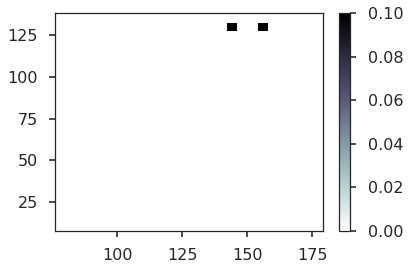

In [16]:
fig, ax = plt.subplots()

xx, yy = np.meshgrid(xedges, yedges)

pad_amount = 5
ax.set_xlim((np.floor(np.min(true_position.x))-pad_amount, np.ceil(np.max(true_position.x))+pad_amount))
ax.set_ylim((np.floor(np.min(true_position.y))-pad_amount, np.ceil(np.max(true_position.y))+pad_amount))

n_timebins = len(likelihood)

cmap = plt.cm.get_cmap('bone_r')
posterior_position = ax.pcolormesh(xx[:-1], yy[:-1], sum_likelihood, vmin=0, vmax=0.1, cmap=cmap)
colorbar = plt.colorbar(posterior_position, ax=ax)